In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee

The purpose of this notebook is to provide a walkthrough of my thought process behind my decisions/code. In this notebook, I will use MCMCs and data from the Planck Public Release II to constrain various cosmological parameters. 

### Importing pypico

Pypico (Parameters for the Impatient Cosmologist) is a package that computes the CMB power spectra and matter transfer functions at a much quicker rate versus other packages (such as CAMB). It does this by interpolating through "training data", which for the purpose of this project, will be sufficient enough. The test data was obtained from [https://github.com/marius311/pypico-trainer/releases](here). 

In [2]:
import pypico
path_to_data = '/home/mattias/Desktop/McGill/W2022/PHYS321-Final-Project/data/jcset_py3.dat'
pico = pypico.load_pico(path_to_data)

In [3]:
# This data will accept the following input cosmological parameters: 
pico.inputs()

['As', 'ns', 'tau', 'ombh2', 'omch2', 'H0', 'omk']

In [4]:
# The outputted quantity can be obtained by calling
pico.outputs()

['cl_TT']

In [5]:
# Finally, to obtain the result, we define a dictionary of parameters with keys for each input
# To get a sample set of inputs, we can call
pico.example_inputs()

{'As': 2.08e-09,
 'ns': 0.97,
 'tau': 0.055,
 'ombh2': 0.0225,
 'omch2': 0.117,
 'H0': 50,
 'omk': -0.05,
 'pivot_scalar': 0.05}

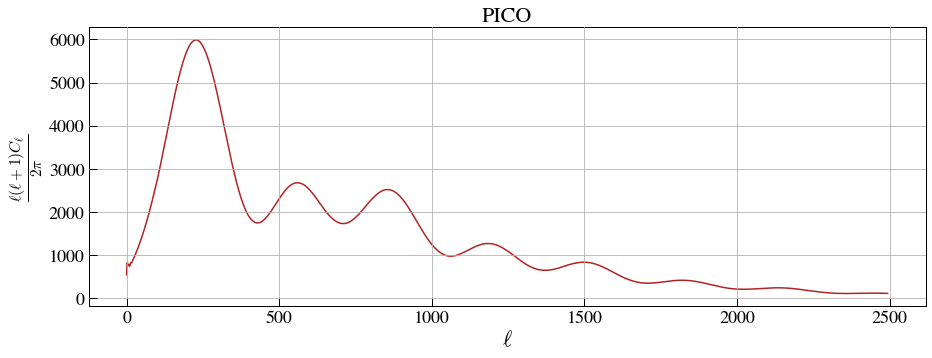

In [6]:
# Now we can get our results 
As, ns, tau, ombh2, omch2, H0, omk = 2e-9, 0.97, 0.055, 0.023, 0.1, 60, -0.05
inputs = {'As':As, 'ns':ns, 'tau':tau, 'ombh2':ombh2, 'omch2':omch2, 'H0':H0}
output = pico.get(**inputs, omk=0)
dl_TT = output['dl_TT']
npts_simulation = len(dl_TT)

# Plot
plt.figure(figsize=(15,5))
plt.plot(dl_TT, color='firebrick')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\frac{\ell(\ell +1)C_\ell}{2\pi}$')
plt.grid()
plt.title('PICO')
plt.show()


### Loading in the Planck Spectrum

In [7]:
planck = np.loadtxt('data/COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows = 1)
spectrum = planck[:,1]
errors = 0.5*(planck[:,2] + planck[:,3])
npars = 6
l = np.arange(0,npts_simulation)

# Shorten planck to match pico data
spectrum = spectrum[0:npts_simulation]
errors = errors[0:npts_simulation]

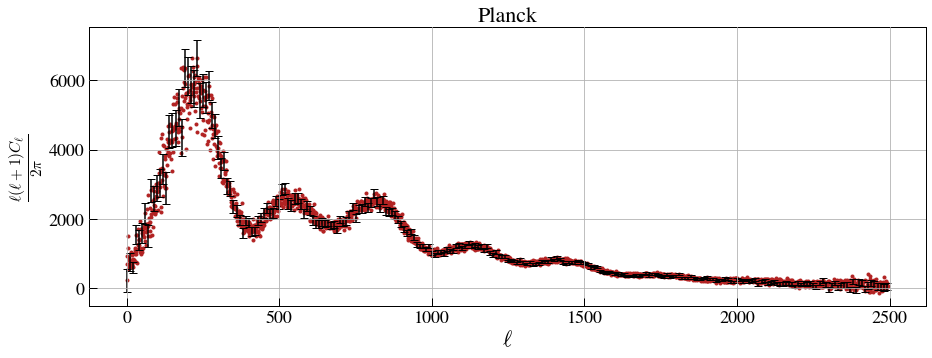

In [8]:
# Plot
plt.figure(figsize=(15,5))
plt.plot(spectrum, '.', color='firebrick' )
plt.errorbar(l, spectrum, yerr=errors,errorevery=10, linestyle = 'None',capsize=4, color='black', ms=8)
plt.xlabel(r'$\ell$')
plt.title('Planck')
plt.ylabel(r'$\frac{\ell(\ell +1)C_\ell}{2\pi}$')
plt.grid()
plt.show()


## MCMC #1: Gaussian Errorbars

The parameters we are interested in determing are the following: $A_s, n_s, \tau, \Omega_bh^2, \Omega_ch^2, H_0$. As an intial attempt, we'll assume Gaussian errors on all of the parameters and uniform priors on all values. The likelihood is given by: 
\begin{equation}
p(y_i|A_s, n_s, \tau, \Omega_bh^2, \Omega_ch^2, H_0) = \prod_i^N \frac{\text{exp}\left[\frac{-[y_i - f(A_s, n_s, \tau, \Omega_bh^2, \Omega_ch^2, H_0)]^2 }{2\sigma_i^2}\right]}{\sqrt{2\pi\sigma_i^2}}
\end{equation}

In [9]:
# Define our pico emulator 
pico = pypico.load_pico(path_to_data)

def guess_initial_pars(nwalkers, ndim = 6):
    '''
    Generates randomly distributed values for each of the initial parameters
    
    Parameters:
    -----------
    nwalkers: int
        number of walkers for emcee
    ndim: int (default 6)
        number of parameters. Hardcoded to 6 for this notebook. 
    '''
    initial_pos = np.empty((nwalkers, ndim))

    As_guess = 2e-9 + 1e-11*np.random.randn(nwalkers)
    ns_guess = 0.97 + 0.001*np.random.randn(nwalkers)
    tau_guess = 0.055 + 0.0001*np.random.randn(nwalkers)
    ombh2_guess = 0.023 + 0.0001*np.random.randn(nwalkers)
    omch2_guess = 0.1 + 0.001*np.random.randn(nwalkers)
    H0_guess = 60 + 1*np.random.randn(nwalkers)

    initial_pos[:,0] = As_guess
    initial_pos[:,1] = ns_guess
    initial_pos[:,2] = tau_guess
    initial_pos[:,3] = ombh2_guess
    initial_pos[:,4] = omch2_guess
    initial_pos[:,5] = H0_guess
    
    return initial_pos

# Let's combine this into a single function so we can use it later 
def get_spectrum(pars):
    '''
    Computes the power spectrum for a given set of parameters. 
    
    Parameters:
    -----------
    pars: dictionary 
        Dictionary containing input parameters as keys and value as value. The following parameters must be specified: 
            1. As
            2. ns
            3. tau
            4. omch2
            5. ombh2
            6. omk
            7. H0
    '''
    # Get spectrum (output is a dictionary)
    spec_dict = pico.get(**pars, omk=0)
    dl_TT = spec_dict['dl_TT']
    
    return dl_TT

def generate_dict(params):
    # Puts params into a dictionary
    As, ns, tau, ombh2, omch2, H0 = params
    temp_dict = {'As':As, 'ns':ns, 'tau':tau, 'ombh2':ombh2, 'omch2':omch2, 'H0':H0}
    
    return temp_dict

def log_likelihood(params, y, yerr):
    
    temp_dict = generate_dict(params)
    
    # Use PICO bounds as prior
    try: 
        pico.get(**temp_dict, omk = 0)
    except: 
        return -np.inf
    
    else: 
        # Get our model y values
        model = get_spectrum(temp_dict)

        # Get variance 
        sigma2 = yerr ** 2

        return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

At this point, we're ready to run the MCMC and plot the results. Let's see how we do! 

In [ ]:
num_iter = 10000
nwalkers = 50
ndim=6

# Get initial position for MCMC
initial_pos = guess_initial_pars(nwalkers)

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(spectrum, errors))
sampler.run_mcmc(initial_pos, num_iter, progress=True);

samples = sampler.get_chain()

# Discard first 10% of sample to omit burn in period
flat_samples = sampler.get_chain(discard=int(num_iter*0.1), thin=15, flat=True)

# Save data to disk for future analysis
path = '/home/mattias/Desktop/McGill/W2022/PHYS321-Final-Project/data/chains_v5.npy'
np.save(path, flat_samples)

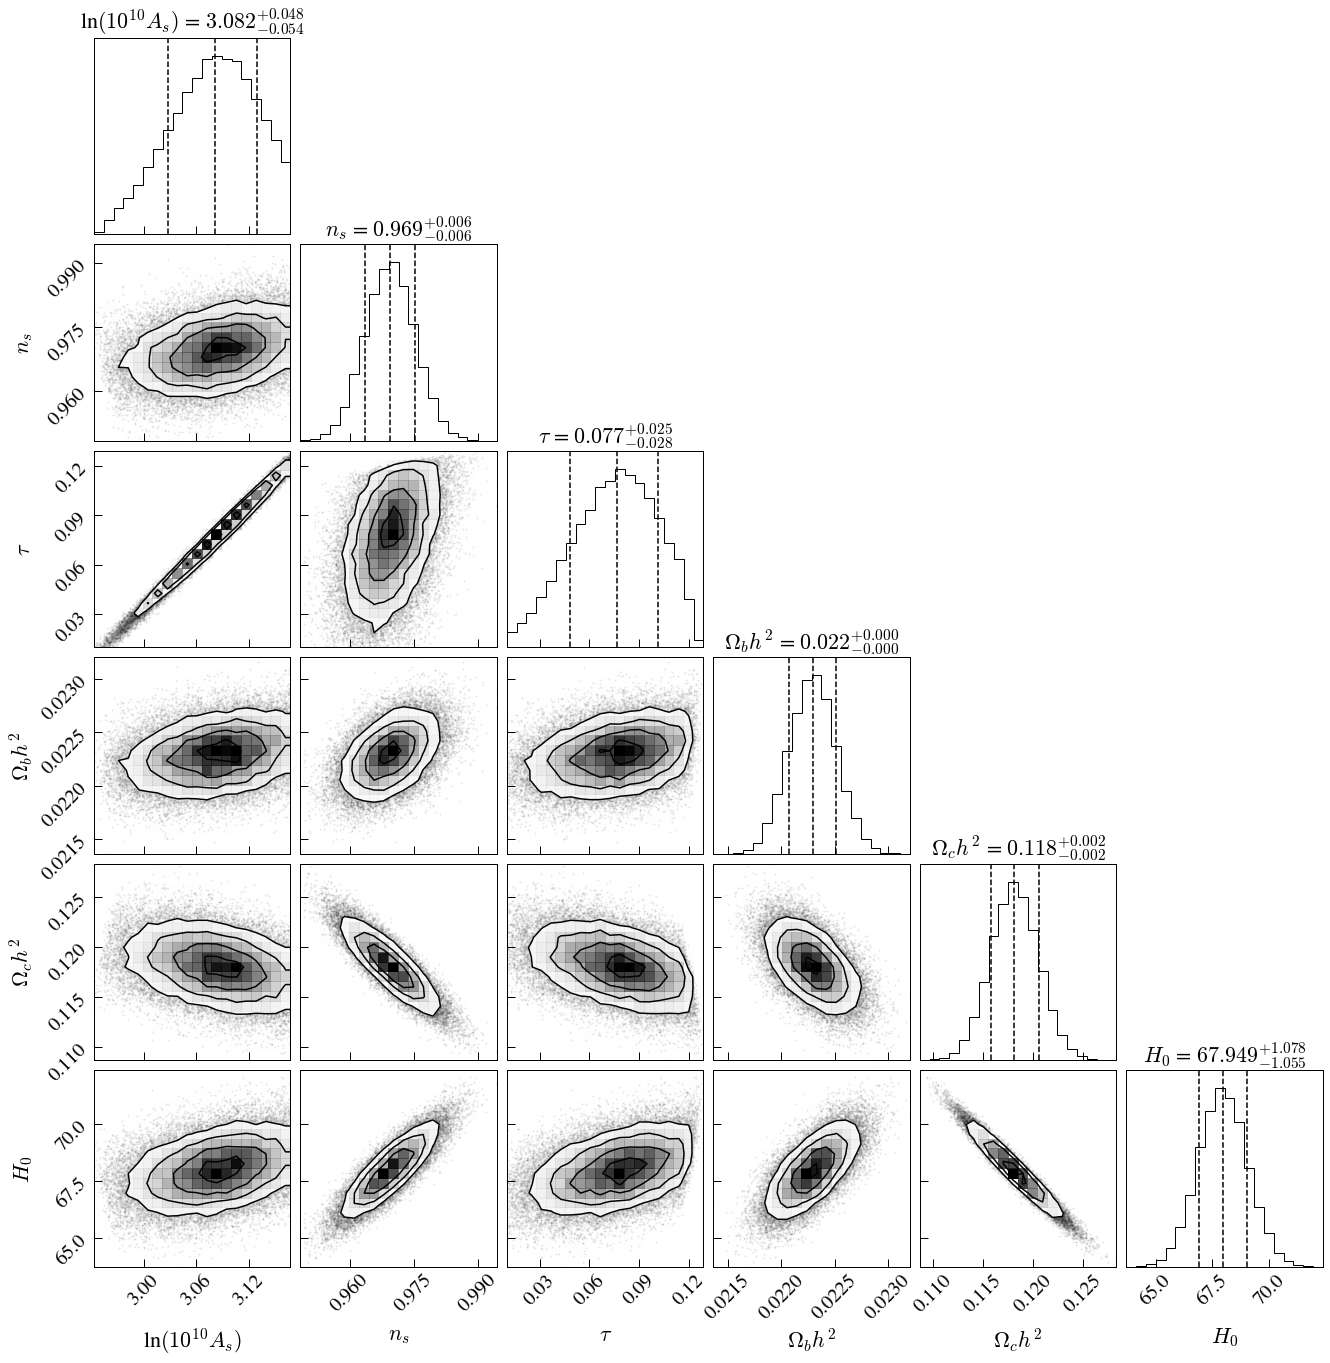

In [49]:
%matplotlib inline

# Load in data 
path = '/home/mattias/Desktop/McGill/W2022/PHYS321-Final-Project/data/chains_v5.npy'
flat_samples_load_gauss = np.load(path)

# Re-scale amplitude
flat_samples_load_gauss[:,0] = np.log(np.power(10,10)*flat_samples_load_gauss[:,0])

# Plot corner plot
labels = [r'ln$(10^{10}A_s)$', r'$n_s$', r'$\tau$', r'$\Omega_bh^2$', r'$\Omega_ch^2$', r'$H_0$']
fig = corner.corner(flat_samples_load_gauss, labels=labels, show_titles=True,title_fmt='.3f', quantiles=[0.16, 0.5, 0.84], max_n_ticks=4);

fig.subplots_adjust(right=1.3,top=1.3)
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=20)
    
plt.savefig('corner_gauss.png', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
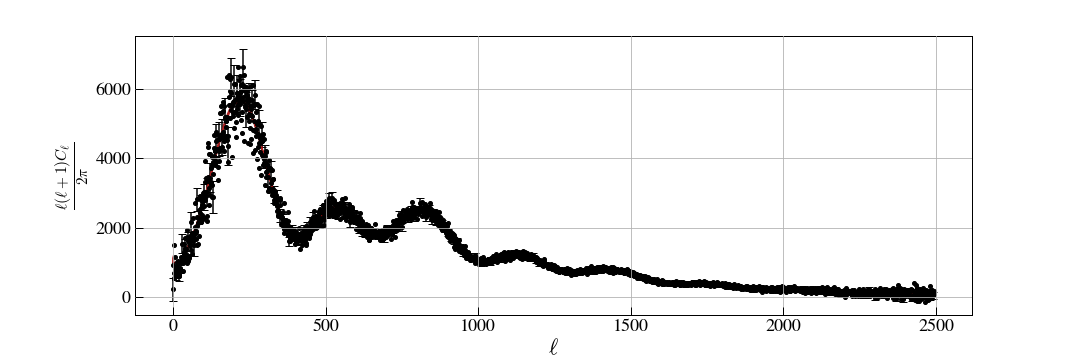

In [50]:
# Plot random selection of parameters 
%matplotlib widget
inds = np.random.randint(len(flat_samples_load_gauss), size=100)
f, ax = plt.subplots(figsize=(15,5))
l = np.arange(0,len(spectrum))
ax.errorbar(l, spectrum, yerr=errors,errorevery=10, linestyle = 'None',capsize=4, marker ='.', color='black', ms=8)
for ind in inds:
    As, ns, tau, ombh2, omch2, H0 = flat_samples_load_gauss[ind]
    temp_dict = {'As':np.exp(As)/np.power(10,10), 'ns':ns, 'tau':tau, 'ombh2':ombh2, 'omch2':omch2, 'H0':H0}
    yfit = get_spectrum(temp_dict)
    ax.plot(yfit, alpha=0.05, color='firebrick')

ax.grid()
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\ell(\ell +1)C_\ell}{2\pi}$')
plt.show()


Using the interactive plot, we can see that by zooming in, the MCMC is sampling different values that are visibly modelling the data very well. Lastly, we plot the best fit results and obtain the residuals. 

In [13]:
def get_best_fit(posterior):
    
    # Get median of each sample
    best_fit_params = np.median(posterior, axis = 0)
    
    # Get dictionary 
    temp_dict = generate_dict(best_fit_params)
    
    # Get spectrum 
    best_fit = get_spectrum(temp_dict)
    
    return best_fit 

def get_residuals(spectrum, ydata, yerr, ndim = 6):
    
    # Compute residuals
    residuals = ydata - spectrum
    
    # Compute chisq
    chisq = np.sum(np.power(residuals/yerr,2))
    # Number of degrees of freedom
    ndof = len(ydata) - ndim
    # Reduced chisq
    red_chisq = chisq/ndof
    
    print(r'Reduced χ2 = {0}$'.format(red_chisq))
    
    return residuals

Reduced χ2 = 1.0266500556806173$


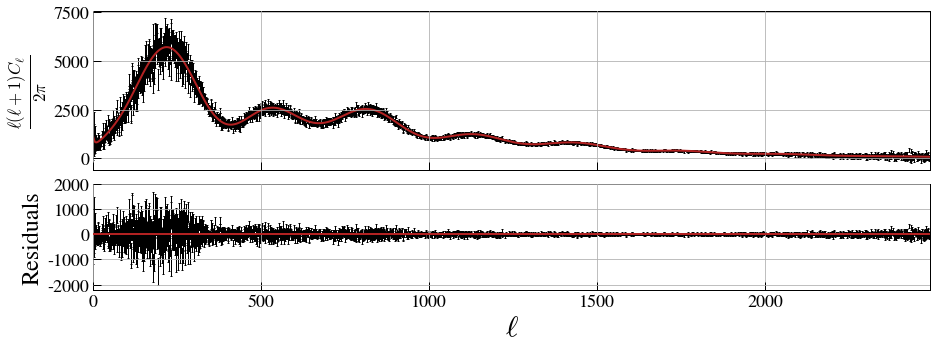

In [52]:
%matplotlib inline

# Re-scale back to normal amplitude
flat_samples_load_gauss[:,0] = np.exp(flat_samples_load_gauss[:,0])/np.power(10,10)

# Get best fit 
best_fit_gauss = get_best_fit(flat_samples_load_gauss)

# Get residuals
resids_gauss = get_residuals(best_fit_gauss, spectrum, errors)

# Plot final results

fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios':[1.5,1]}, figsize = (15,5))

ax[0].plot(l,best_fit_gauss, label = 'Fit', color = 'firebrick', linewidth = 2, zorder=2)
ax[0].errorbar(l, spectrum, yerr=errors,errorevery=1,capsize=1, color='black', ms=8, linewidth=1, zorder=1, ls = 'none')
ax[0].set_ylabel(r'$\frac{\ell(\ell +1)C_\ell}{2\pi}$', fontsize=24)
ax[0].grid()
ax[0].tick_params(axis='x', labelbottom=False)
ax[0].set_xlim(l[0],l[-1])

ax[1].errorbar(l, resids_gauss, yerr=errors,errorevery=1,capsize=1, color='black', ms=8, linewidth=1, zorder=1, ls = 'none')
ax[1].hlines(y = 0, xmin = l[0], xmax = l[-1], color = 'firebrick', linewidth=2, zorder=3)
ax[1].set_ylabel('Residuals', fontsize=24)
ax[1].set_xlabel(r'$\ell$', fontsize=30)
ax[1].set_xlim(l[0],l[-1])
ax[1].set_yticks(np.arange(-2000,2001,1000))
ax[1].grid()

fig.subplots_adjust(wspace=0.1,hspace=0.1)

plt.savefig('gaussian_llhd.png', bbox_inches='tight')

# Cauchy Distribution

Suppose instead now that our parameters are Lorentzian distributed such that the likelihood is now
\begin{equation}
\mathcal{L} = \frac{1}{\pi}\left[\frac{\frac{1}{2}\Gamma}{(y_i-f(A_s, n_s, \tau, \Omega_bh^2, \Omega_ch^2, H_0))^2 + \frac{\Gamma^2}{4}}\right],
\end{equation}
where $\Gamma$ is the FWHM. Assuming Gaussianity on the errorbars, we can relate the FWHM to the errorbars by
\begin{equation}
\Gamma_i = 2\sqrt{2\text{log}2}\sigma_i
\end{equation}


For `emcee`, we require the log likelihood, which in this case is simply
\begin{equation}
\text{log}\mathcal{L} = \sum_{i=1}^{N}\left[-\text{log}\left((y_i - f(A_s, n_s, \tau, \Omega_bh^2, \Omega_ch^2, H_0))^2 + \frac{\Gamma_i^2}{4}\right) + \text{log}\left(\frac{\Gamma_i^2}{4}\right) \right]
\end{equation}

In [15]:
# Convert our gaussian errorbars to FWHM parameters 
Γ = 2*np.sqrt(2*np.log(2))*errors

In [16]:
# Define our new llhd
def log_likelihood_lorentzian(params, y, FWHM):
    
    As, ns, tau, ombh2, omch2, H0 = params
    
    temp_dict = {'As':As, 'ns':ns, 'tau':tau, 'ombh2':ombh2, 'omch2':omch2, 'H0':H0}
    
    try: 
        pico.get(**temp_dict, omk = 0)
    except: 
        return -np.inf
    
    else: 
        # Get our model y values
        model = get_spectrum(temp_dict)

        # Get variance 
        FWHM2 = FWHM ** 2

        return np.sum(np.log(FWHM/(2*np.pi)) - np.log((y - model)**2 + FWHM2/4))

In [17]:
num_iter = 10000
nwalkers = 50

initial_pos = guess_initial_pars(nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_lorentzian, args=(spectrum, Γ))
sampler.run_mcmc(initial_pos, num_iter, progress=True);

samples = sampler.get_chain()


100%|█████████████████████████████████████| 10000/10000 [07:16<00:00, 22.91it/s]


In [18]:
flat_samples_lorentz = sampler.get_chain(discard=int(num_iter*0.1), thin=15, flat=True)

# Save data to disk for future analysis
path = '/home/mattias/Desktop/McGill/W2022/PHYS321-Final-Project/data/chains_v3_cauchy.npy'
np.save(path, flat_samples_lorentz)

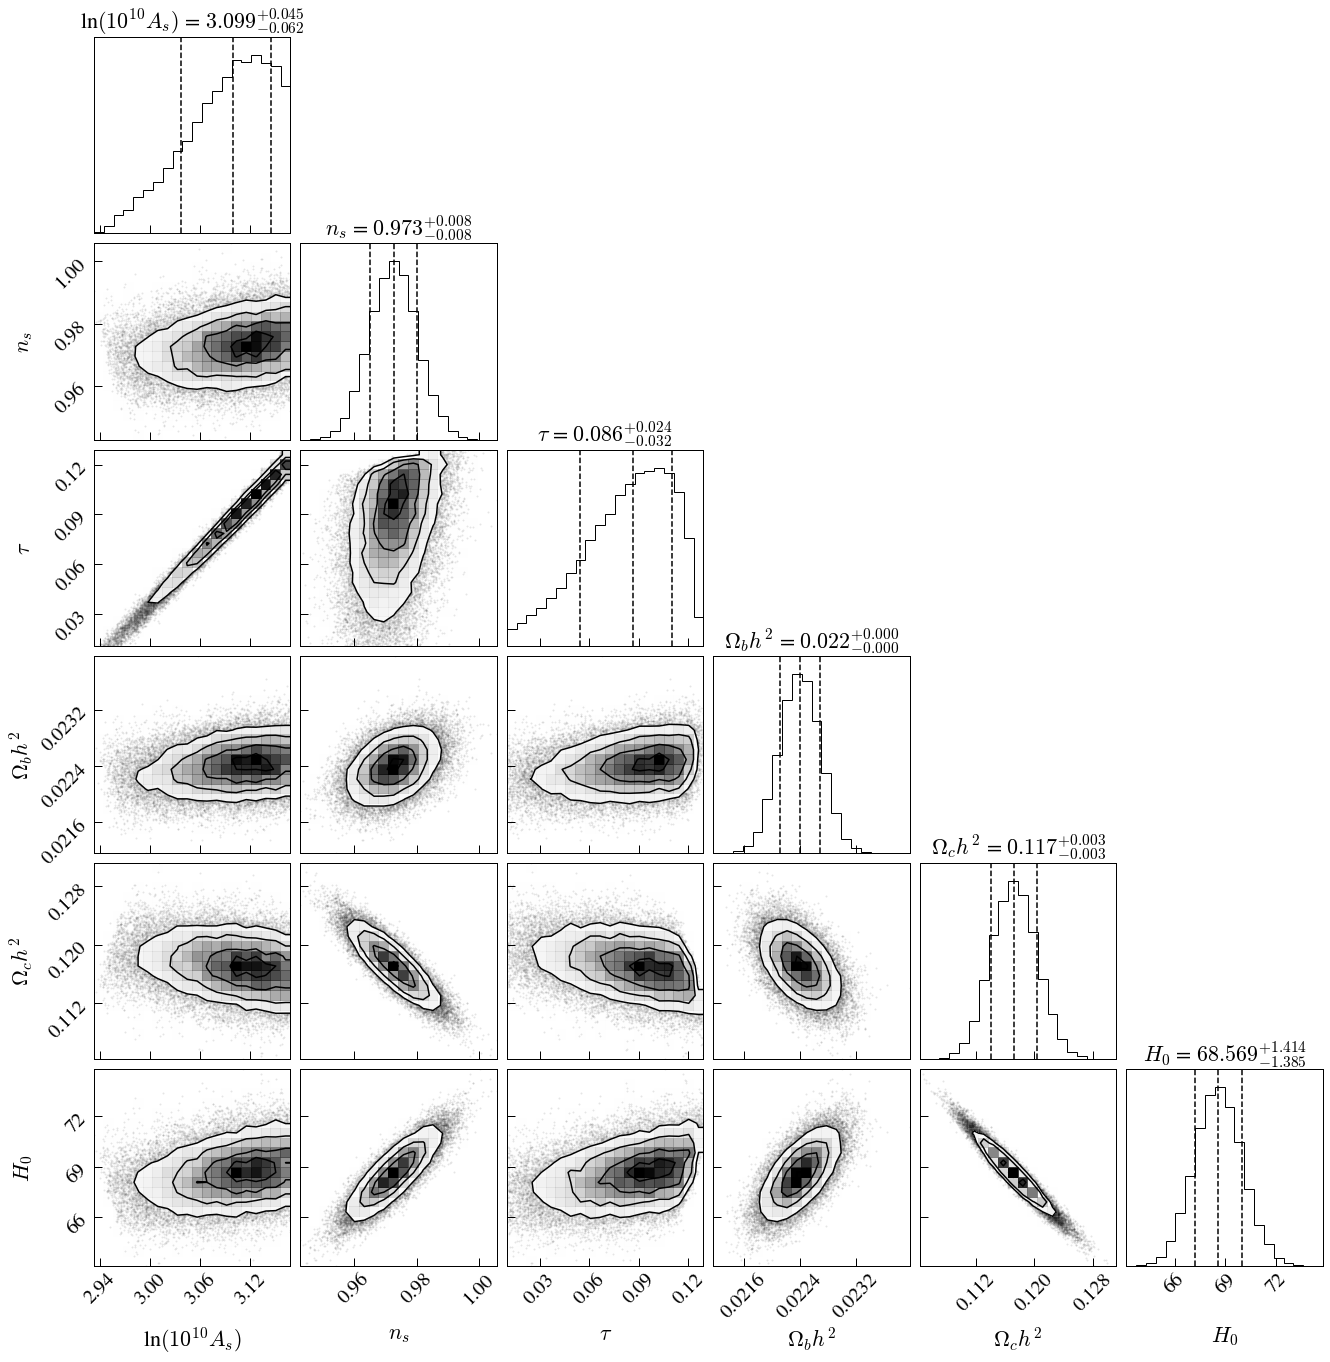

In [45]:
# Load in data 
path = '/home/mattias/Desktop/McGill/W2022/PHYS321-Final-Project/data/chains_v3_cauchy.npy'

%matplotlib inline
flat_samples_load_lorentz = np.load(path)

# Re-scale amplitude
flat_samples_load_lorentz[:,0] = np.log(np.power(10,10)*flat_samples_load_lorentz[:,0])

# Plot corner plot
labels = [r'ln$(10^{10}A_s)$', r'$n_s$', r'$\tau$', r'$\Omega_bh^2$', r'$\Omega_ch^2$', r'$H_0$']
fig = corner.corner(flat_samples_load_lorentz, labels=labels, show_titles=True,title_fmt='.3f', quantiles=[0.16, 0.5, 0.84], max_n_ticks=4);

fig.subplots_adjust(right=1.3,top=1.3)
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=20)
    
plt.savefig('corner_lorentz.png', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
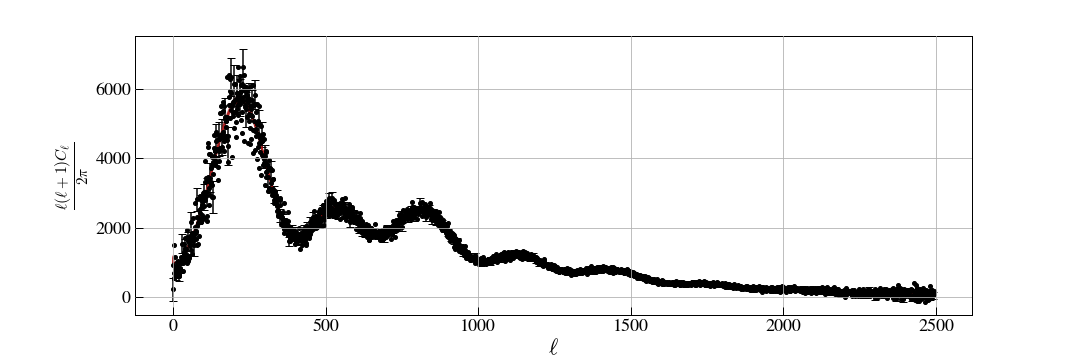

In [47]:
# Plot random selection of parameters 
%matplotlib widget
inds = np.random.randint(len(flat_samples_load_lorentz), size=100)
f, ax = plt.subplots(figsize=(15,5))
l = np.arange(0,len(spectrum))
ax.errorbar(l, spectrum, yerr=errors,errorevery=10, linestyle = 'None',capsize=4, marker ='.', color='black', ms=8)
for ind in inds:
    As, ns, tau, ombh2, omch2, H0 = flat_samples_load_lorentz[ind]
    temp_dict = {'As':np.exp(As)/np.power(10,10), 'ns':ns, 'tau':tau, 'ombh2':ombh2, 'omch2':omch2, 'H0':H0}
    yfit = get_spectrum(temp_dict)
    ax.plot(yfit, alpha=0.05, color='firebrick')

ax.grid()
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\ell(\ell +1)C_\ell}{2\pi}$')
plt.show()

Everything is looking good, so let's plot the best fit and residuals like we did before: 

Reduced χ2 = 1.0271529252797726$


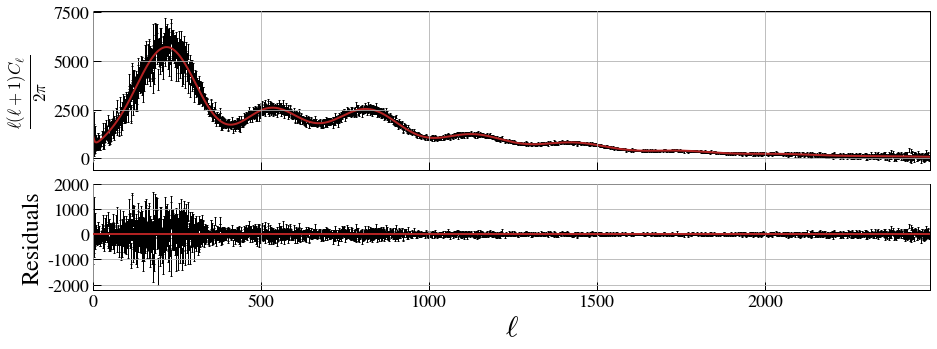

In [53]:
%matplotlib inline

# Re-scale back to normal amplitude
flat_samples_load_lorentz[:,0] = np.exp(flat_samples_load_lorentz[:,0])/np.power(10,10)

# Get best fit 
best_fit_lorentz = get_best_fit(flat_samples_load_lorentz)

# Get residuals
resids_lorentz = get_residuals(best_fit_lorentz, spectrum, errors)

# Plot final results
fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios':[1.5,1]}, figsize = (15,5))

ax[0].plot(l,best_fit_lorentz, label = 'Fit', color = 'firebrick', linewidth = 2, zorder=2)
ax[0].errorbar(l, spectrum, yerr=errors,errorevery=1,capsize=1, color='black', ms=8, linewidth=1, zorder=1, ls = 'none')
ax[0].set_ylabel(r'$\frac{\ell(\ell +1)C_\ell}{2\pi}$', fontsize=24)
ax[0].grid()
ax[0].tick_params(axis='x', labelbottom=False)
ax[0].set_xlim(l[0],l[-1])

ax[1].errorbar(l, resids_lorentz, yerr=errors,errorevery=1,capsize=1, color='black', ms=8, linewidth=1, zorder=1, ls = 'none')
ax[1].hlines(y = 0, xmin = l[0], xmax = l[-1], color = 'firebrick', linewidth=2, zorder=3)
ax[1].set_ylabel('Residuals', fontsize=24)
ax[1].set_xlabel(r'$\ell$', fontsize=30)
ax[1].set_xlim(l[0],l[-1])
ax[1].set_yticks(np.arange(-2000,2001,1000))
ax[1].grid()

fig.subplots_adjust(wspace=0.1,hspace=0.1)

plt.savefig('lorentzian_llhd.png', bbox_inches='tight')

## Plotting the difference in the results

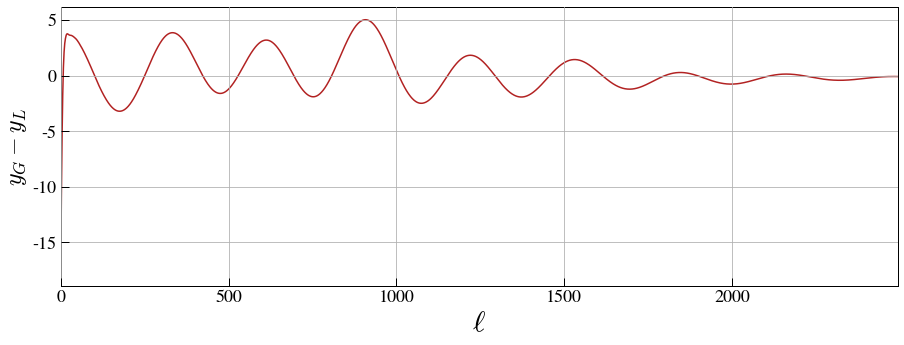

In [22]:
plt.figure(figsize=(15,5))
plt.plot(l, best_fit_gauss - best_fit_lorentz, color = 'firebrick')
plt.ylabel(r'$y_G - y_L$', fontsize=24)
plt.xlabel(r'$\ell$', fontsize=30)
plt.xlim(l[0], l[-1])
plt.grid()